In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score

In [2]:
ENCRYPTED_DIRECTORY = "data/govdocs_encrypted"
PLAINTEXT_DIRECTORY = "data/govdocs_plaintext"

In [3]:
def load_data(directory):
    dataframes = list()
    for f in glob.glob(f"{directory}/**.parquet.gzip"):
        df = pd.read_parquet(f)
        dataframes.append(df)
    return pd.concat(dataframes)

df_plaintext = load_data(PLAINTEXT_DIRECTORY)
df_plaintext["is_encrypted"] = 0
df_encrypted = load_data(ENCRYPTED_DIRECTORY)
df_encrypted["is_encrypted"] = 1

master_df = pd.concat([df_plaintext, df_encrypted])

# Filter out only webp
# master_df = master_df[master_df['extended.extension'] != '.webp']
print("only webp: ", master_df.shape)

# Filter out files which are larger than 4k
#master_df = master_df[master_df['baseline.filesize'] > 4096]
print("greater than 4096: ", master_df.shape)

# Shuffle
master_df = master_df.sample(frac=1).reset_index(drop=True)

# fill Nan with 0
master_df['baseline.chisquare_end'] = master_df['baseline.chisquare_end'].fillna(0.0)
master_df.dropna(inplace=True)


only webp:  (161706, 19)
greater than 4096:  (161706, 19)


In [4]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[[c for c in X.columns if c != 'is_encrypted']]

# get rid of tail and head metrics
X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [5]:
rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression())]
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
print(precision, recall, fscore, support)
print(f"F1 = {f1_score(y_test, y_pred)}")

[0.63391514 0.63106686] [0.56368745 0.6962926 ] [0.59674221 0.66207715] [7474 8011]
F1 = 0.6620771513353116


                                  count          mean           std  \
baseline.shannon_entropy       139364.0  7.350344e+00  1.260643e+00   
baseline.montecarlo_pi         139364.0  3.112903e+00  4.124760e-01   
baseline.chisquare_full        139364.0  1.352464e+07  7.167910e+07   
baseline.autocorrelation_full  139364.0  9.523400e-02  1.761586e-01   
baseline.filesize              139364.0  3.252459e+05  1.609189e+06   
advanced.kurtosis_full         139364.0 -9.528688e-01  1.177777e+00   
advanced.skew_full             139364.0  4.071471e-02  4.613112e-01   

                                     min            25%           50%  \
baseline.shannon_entropy        0.551224       7.718953  7.977289e+00   
baseline.montecarlo_pi          0.000000       3.119221  3.134029e+00   
baseline.chisquare_full        33.456250  368190.579368  1.558139e+06   
baseline.autocorrelation_full  -0.798039      -0.000434  5.349282e-03   
baseline.filesize               7.000000   11740.000000  4.003000e

<BarContainer object of 7 artists>

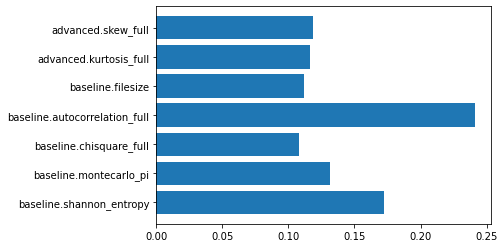

In [6]:
#df1 = master_df[X_train.isna().any(axis=1)]
#print(df1)
print(X_train.describe().T)
print(rfc.feature_importances_)
plt.barh(X_train.columns, rfc.feature_importances_)